# 1. Starting point

## 데이터 구조

# 2. Library Import

In [1]:
import os
from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Add, Input, Dense, Conv2D, Flatten, MaxPool2D, UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose, Concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

## 사전 작업

# 3. 데이터 살펴보기

Input image


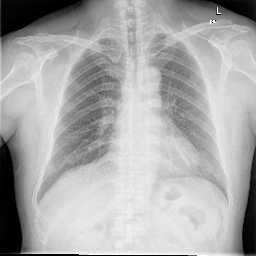

Right lung mask


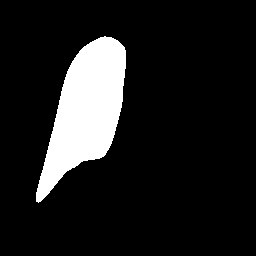

Left lung mask


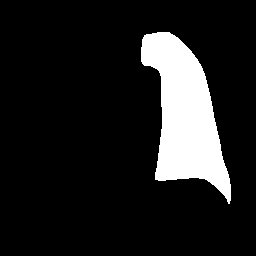

In [2]:
from IPython.display import Image, display

print("Input image")
display(Image('./data/image/resize_CHNCXR_0001_0.png'))
print("Right lung mask")
display(Image('./data/label_rl/r/resize_CHNCXR_0001_0.png'))
print("Left lung mask")
display(Image('./data/label_rl/l/resize_CHNCXR_0001_0.png'))

## 픽셀 히스토그램 살펴보기

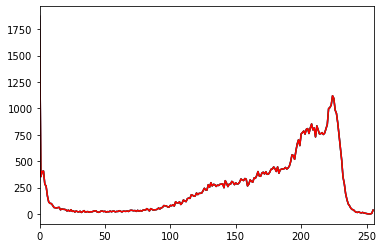

In [3]:
# image sample
image_sample = cv2.imread('./data/image/resize_CHNCXR_0001_0.png')
color = ('b', 'g', 'r')
for i, col in enumerate(color):
    histr = cv2.calcHist([image_sample], [i], None, [256], [0, 256])
    plt.plot(histr, color = col)
    plt.xlim([0, 256])
plt.show()

(256, 256, 3)


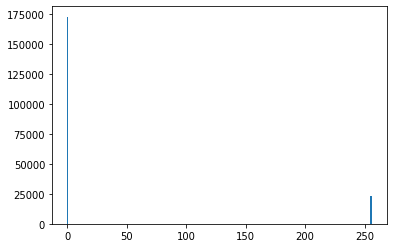

In [4]:
# mask sample
mask_sample = cv2.imread('./data/label_rl/r/resize_CHNCXR_0001_0.png')#, cv2.IMREAD_GRAYSCALE)
print(mask_sample.shape)

plt.hist(mask_sample.ravel(), 256, [0, 256])
plt.show()

In [5]:
# hyper parameter
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
N_CLASSES = 3
EPOCHS = 80
BATCH_SIZE = 32

In [6]:
data_path = './data/'

files = os.listdir(os.path.join(data_path, 'image'))
file_headers = [] # 현재 디렉터리 파일 리스트
for f in files:
    f1 = os.path.splitext(f)[0] # splitext (이미지 이름, 확장자)
    file_headers.append(f1)
    
X_all = np.zeros((len(file_headers), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8) # Input image
y_all = np.zeros((len(file_headers), IMG_HEIGHT, IMG_WIDTH, N_CLASSES), dtype=np.bool) # label

count = 0
for fh in tqdm(file_headers):
    f1 = os.path.join(data_path, 'image', '{}.png'.format(fh))           # image list
    label_r = os.path.join(data_path, 'label_rl/r', '{}.png'.format(fh)) # r label image list
    label_l = os.path.join(data_path, 'label_rl/l', '{}.png'.format(fh)) # l label image list
    
    img = imread(f1)[:, :, :IMG_CHANNELS]
#     print(img.shape) # (256, 256, 3)

    """
    ■ label
        ● background: 0
        ● Left lung:  1 
        ● Right lung: 2
    
    아래 코드에서의 레이블 영역 생성 흐름
    : 1. mask_r 이미지의 (우측 폐) 영역 1, 배경 영역 0
      2. mask_l 이미지의 (좌측 폐) 영역 1, 배경 영역 0
      3. mask 변수에 mask_r과 mask_l을 덧셈 연산(cv2.add)한다.
      4. mask 변수에 mask_r을 덧셈 연산한다.
      5. 3번의 과정에서 생긴 이미지는 좌우측 폐가 1을 가지고 배경은 0을 가진다.
         4번의 과정을 거치면서 우측 폐 영역의 덧셈 연산이 일어나고 우측 폐가 2를 가진다.
      6. 배경 0, 좌측 폐 1, 우측 폐 2를 가진 이미지(256, 256, 1)를 원핫 인코딩을 하고 저장한다.
    """
    
    mask_r = imread(label_r, as_gray=True) # (256, 256)    
    mask_r[mask_r == 1] = 1
    mask_r[mask_r != 1] = 0
    
    mask_l = imread(label_l, as_gray=True) # (256, 256)
    mask_l[mask_l == 1] = 1
    mask_l[mask_l != 1] = 0
    
    mask = cv2.add(mask_r, mask_l)
    mask = cv2.add(mask, mask_r) # (256, 256)

    mask = np.expand_dims(mask, axis = -1) # 차원 증가
    mask = tf.keras.utils.to_categorical(y = mask, num_classes = N_CLASSES) # 원핫 인코딩
    
    X_all[count] = img
    y_all[count] = mask

    count += 1

100%|████████████████████████████████████████████████████| 566/566 [00:12<00:00, 45.49it/s]


In [7]:
print(X_all.shape)
print(y_all.shape)

(566, 256, 256, 3)
(566, 256, 256, 3)


**딥러닝을 위한 데이터 전처리**

In [8]:
X_all = X_all.astype('float32') / 255. # 픽셀 정규화
y_all = y_all.astype('float32')

In [9]:
# fix random seed for reproductibility
seed = 7
np.random.seed(seed)

# data slicing
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [10]:
print('X_train',X_train.shape)
print('X_valid',X_valid.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('y_valid',y_valid.shape)
print('y_test',y_test.shape)

X_train (361, 256, 256, 3)
X_valid (91, 256, 256, 3)
X_test (114, 256, 256, 3)
y_train (361, 256, 256, 3)
y_valid (91, 256, 256, 3)
y_test (114, 256, 256, 3)


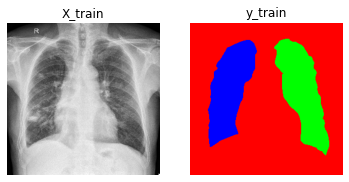

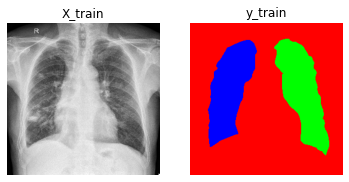

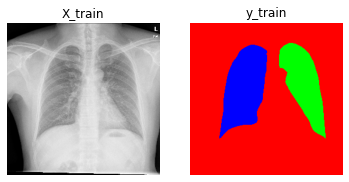

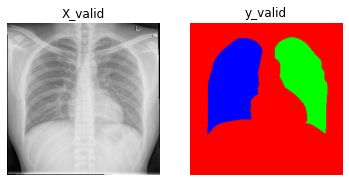

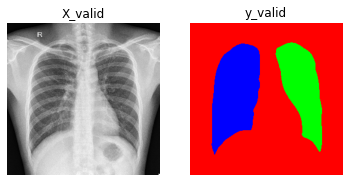

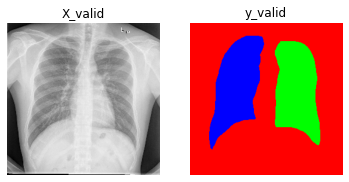

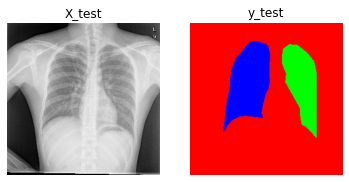

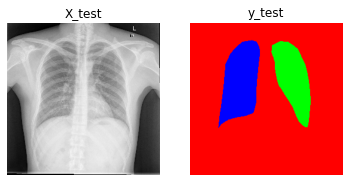

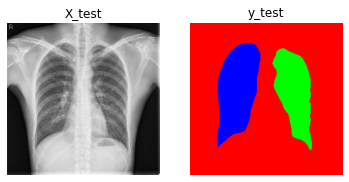

In [11]:
def plotTrainData(a,b,c):
    for i in range(3):
        ix = np.random.randint(0, len(a))
        plt.subplot(1,2,1)
        plt.title("X_" + c)
        plt.imshow(a[ix])
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.title("y_" + c)
        plt.imshow(np.squeeze(b[ix]))#, 'gray')
        plt.axis('off')
        plt.show()
        
plotTrainData(X_train,y_train, 'train')
plotTrainData(X_valid,y_valid, 'valid')
plotTrainData(X_test,y_test, 'test')

In [12]:
# Loss function 계산
# dice coefficient영역이 얼마나 겹치는지를(교집합) 판단하여 오차를 계산한다.(=F1 score)
def dice_coef(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + 1) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# 4. Modeling(U-Net)

![대체 텍스트](https://www.renom.jp/notebooks/tutorial/image_processing/u-net/unet.png)

In [13]:
# U-Net model
# 신경망의 끝단을 MLP가 아닌 CNN을 채택함으로서 기존의 MLP에서의 Flatten으로
# 인한 이미지 특성의 보존이 약해지는 것을 보완하고자 하였다.
# Input: (H, W, C)
# Output: FCN을 사용하여,
#         합성곱(분류 클래스 개수, kernel_size, activation)
# 이미지 해상도를 Maxpooling(<-> Upsampling)하여 줄여나가다(채널은 증가)
# Upsampling으로 작아진 해상도를 늘리며 주변 픽셀을 예측해 값을 채운다.
# 가장 특징적인 점은 Skip connection 기법으로 은닉층을 거칠수록 피쳐맵이 형이상학적인 모양을 띄어가는데
# 그 이전에 초반 레이어 단에서의 비교적 단순한 피쳐맵(수평선, 수직선, 곡선같은 모양)을 Concatenate하여
# 후반 레이어 단에 연결시켜 가중치를 더하는 역할을 한다.
def unet(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPool2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPool2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPool2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPool2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    up6 = Concatenate()([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4])
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up7 = Concatenate()([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3])
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    up8 = Concatenate()([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2])
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up9 = Concatenate()([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1])
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(N_CLASSES, (1, 1), activation='softmax')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [14]:
# build the model
model = unet()
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss=dice_coef_loss,
              optimizer=sgd,
#               optimizer='Adam',
              metrics=[dice_coef])

# fix random seed for reproductibility
seed = 7
np.random.seed(seed)
tf.random.set_seed(seed)

# FIT THE MODEL - OPTIMIZATION
hist = model.fit(X_train, y_train,
                 validation_data=(X_valid, y_valid),
                 epochs=EPOCHS,
                 batch_size=BATCH_SIZE,
                 verbose=1)

Epoch 1/80
12/12 [==============================] - 26s 1s/step - loss: 0.5477 - dice_coef: 0.4530 - val_loss: 0.5936 - val_dice_coef: 0.4065
Epoch 2/80
12/12 [==============================] - 5s 407ms/step - loss: 0.4300 - dice_coef: 0.5701 - val_loss: 0.5450 - val_dice_coef: 0.4553
Epoch 3/80
12/12 [==============================] - 5s 399ms/step - loss: 0.3991 - dice_coef: 0.6011 - val_loss: 0.4796 - val_dice_coef: 0.5209
Epoch 4/80
12/12 [==============================] - 5s 398ms/step - loss: 0.3808 - dice_coef: 0.6194 - val_loss: 0.4397 - val_dice_coef: 0.5609
Epoch 5/80
12/12 [==============================] - 5s 394ms/step - loss: 0.3625 - dice_coef: 0.6375 - val_loss: 0.4243 - val_dice_coef: 0.5763
Epoch 6/80
12/12 [==============================] - 5s 399ms/step - loss: 0.3345 - dice_coef: 0.6658 - val_loss: 0.4199 - val_dice_coef: 0.5808
Epoch 7/80
12/12 [==============================] - 5s 393ms/step - loss: 0.3113 - dice_coef: 0.6888 - val_loss: 0.4234 - val_dice_coef: 0

# 5. Visualization & Predictions

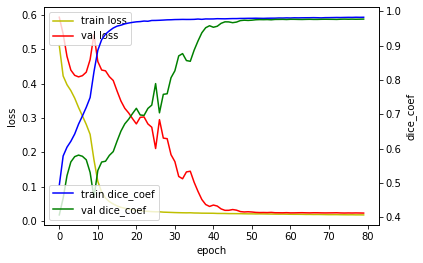

In [15]:
# 학습과정 살펴보기
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['dice_coef'], 'b', label='train dice_coef')
acc_ax.plot(hist.history['val_dice_coef'], 'g', label='val dice_coef')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('dice_coef')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [16]:
# Prediction visualization
def plotPredictions(X_train_, y_train_, X_valid_, y_valid_, X_test_, y_test_, simpleFCN):
    model = simpleFCN     

    ix = np.random.randint(0, len(X_train_))
    input_ = X_train_[ix:ix+1]
    mask_ = y_train_[ix:ix+1]
    preds_train = model.predict(input_)
    preds_train_t = (preds_train > 0.5).astype(np.uint8)
    
    for i in range(3):
        plt.figure(figsize=(10,10))
        
        plt.subplot(1,3,1)
        plt.title("X_train")
        plt.axis('off')
        plt.imshow(input_[0])

        plt.subplot(1,3,2)
        plt.title("Y_train")
        plt.axis('off')
        plt.imshow(mask_[0][:,:,i])#, 'gray')

        plt.subplot(1,3,3)
        ret = model.evaluate(input_, mask_)
        plt.title("Prediction: %.4f" % (ret[1]))
        plt.axis('off')
        plt.imshow(preds_train_t[0][:,:,i])#, 'gray')

        plt.show()   
    
    
        ix = np.random.randint(0, len(X_valid_))
        input_ = X_valid_[ix:ix+1]
        mask_ = y_valid_[ix:ix+1]
        preds_valid = model.predict(input_)
        preds_valid_t = (preds_valid > 0.5).astype(np.uint8)

        plt.figure(figsize=(10,10))

        plt.subplot(1,3,1)
        plt.title("X_valid")
        plt.axis('off')
        plt.imshow(input_[0])

        plt.subplot(1,3,2)
        plt.title("Y_valid")
        plt.axis('off')
        plt.imshow(mask_[0][:,:,i])#, 'gray')

        plt.subplot(1,3,3)
        ret = model.evaluate(input_, mask_)
        plt.title("Prediction: %.4f" % (ret[1]))
        plt.axis('off')
        plt.imshow(preds_valid_t[0][:,:,i])#, 'gray')

        plt.show()
        
        
        ix = np.random.randint(0, len(X_test_))
        input_ = X_test_[ix:ix+1]
        mask_ = y_test_[ix:ix+1]
        preds_test = model.predict(input_)
        preds_test_t = (preds_test > 0.5).astype(np.uint8)

        plt.figure(figsize=(10,10))

        plt.subplot(1,3,1)
        plt.title("X_test")
        plt.axis('off')
        plt.imshow(input_[0])

        plt.subplot(1,3,2)
        plt.title("Y_test")
        plt.axis('off')
        plt.imshow(mask_[0][:,:,i])#, 'gray')

        plt.subplot(1,3,3)
        ret = model.evaluate(input_, mask_)
        plt.title("Prediction: %.4f" % (ret[1]))
        plt.axis('off')
        plt.imshow(preds_test_t[0][:,:,i])#, 'gray')

        plt.show()

1/1 [==============================] - 0s 24ms/step - loss: 0.0262 - dice_coef: 0.9738


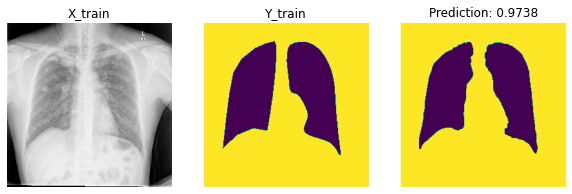

1/1 [==============================] - 0s 21ms/step - loss: 0.0107 - dice_coef: 0.9893


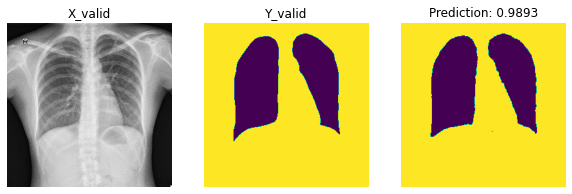

1/1 [==============================] - 0s 21ms/step - loss: 0.0099 - dice_coef: 0.9901


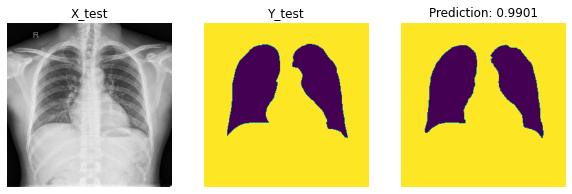

1/1 [==============================] - 0s 23ms/step - loss: 0.0099 - dice_coef: 0.9901


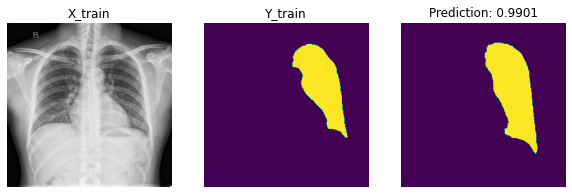

1/1 [==============================] - 0s 22ms/step - loss: 0.0145 - dice_coef: 0.9855


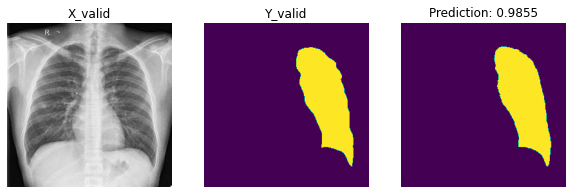

1/1 [==============================] - 0s 20ms/step - loss: 0.0695 - dice_coef: 0.9305


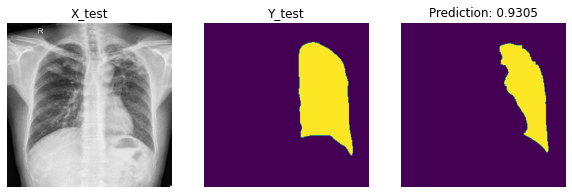

1/1 [==============================] - 0s 21ms/step - loss: 0.0695 - dice_coef: 0.9305


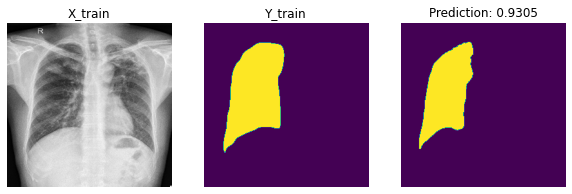

1/1 [==============================] - 0s 20ms/step - loss: 0.0136 - dice_coef: 0.9864


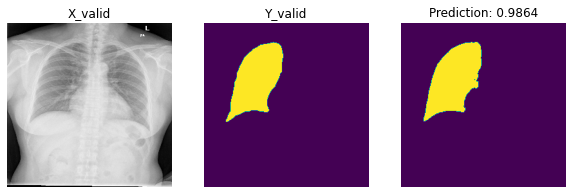

1/1 [==============================] - 0s 23ms/step - loss: 0.0438 - dice_coef: 0.9562


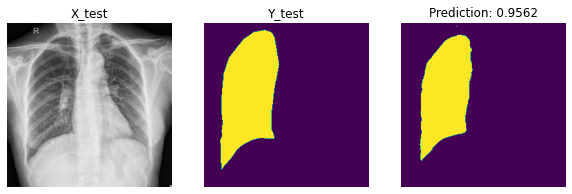

In [17]:
plotPredictions(X_train, y_train, X_valid, y_valid, X_test, y_test, model)